**Import neccesary libraries**

In [ ]:
#for fetching the fetching and storing data
import os
from zipfile import ZipFile
import json

#for image processing
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator

#for model creation
!pip install keras-tuner
import keras_tuner as kt
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense,Conv2D,MaxPooling2D,Flatten,BatchNormalization
from tensorflow.keras.applications import VGG16,ResNet50,InceptionV3,DenseNet201



In [ ]:
!pip install kaggle

**Set the enviornment vaiables & load dataset**

In [ ]:
##Generating credentials
kaggle_cred=json.load(open("kaggle.json"))

##setting up the enviornment variables
os.environ["KAGGLE_USERNAME"]=kaggle_cred["username"]
os.environ["KAGGLE_KEY"]=kaggle_cred["key"]

In [ ]:
!kaggle datasets download -d abdallahalidev/plantvillage-dataset

Dataset URL: https://www.kaggle.com/datasets/abdallahalidev/plantvillage-dataset
License(s): CC-BY-NC-SA-4.0
plantvillage-dataset.zip: Skipping, found more recently modified local copy (use --force to force download)


In [ ]:
##unzip the file
with ZipFile("/content/plantvillage-dataset.zip","r") as zf:
  zf.extractall()

In [ ]:
##checking dataset

print(len(os.listdir("/content/plantvillage dataset/color")))
print(os.listdir("/content/plantvillage dataset/color")[:3])

print(len(os.listdir("/content/plantvillage dataset/color/Apple___Apple_scab")))
print(os.listdir("/content/plantvillage dataset/color/Apple___Apple_scab")[:3])

38
['Grape___Esca_(Black_Measles)', 'Tomato___Tomato_mosaic_virus', 'Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot']
630
['f2d6beb9-e8b1-49f6-b7b7-903b51565435___FREC_Scab 3393.JPG', '01a66316-0e98-4d3b-a56f-d78752cd043f___FREC_Scab 3003.JPG', 'fcee4ece-01ce-45aa-a0f1-f20aa2ec8efb___FREC_Scab 3325.JPG']


(256, 256, 3)


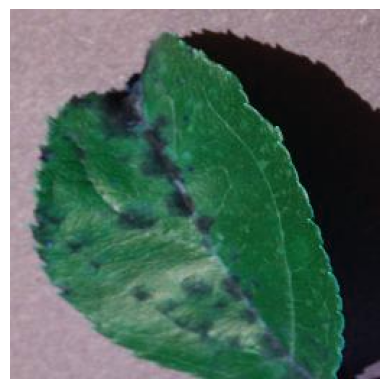

In [ ]:
##Image of sample
img_path="/content/plantvillage dataset/color/Apple___Apple_scab/0261a6e4-21f8-481a-8827-b674e6955644___FREC_Scab 3055.JPG"

img=cv2.imread(img_path)
plt.imshow(img)
plt.axis("off")
print(img.shape)

**Dataset Processsing**

In [ ]:
##data directory
base_dir="/content/plantvillage dataset/color"

##creating datagenerator
data_gen=ImageDataGenerator(
    rescale=1/255,
    validation_split=0.2
)

In [ ]:
##training data
train=data_gen.flow_from_directory(
    base_dir,
    batch_size=32,
    target_size=(224,224),
    subset="training",
    class_mode="categorical"
)

##validation data
validation=data_gen.flow_from_directory(
    base_dir,
    batch_size=32,
    target_size=(224,224),
    subset="validation",
    class_mode="categorical"
)

Found 43456 images belonging to 38 classes.
Found 10849 images belonging to 38 classes.


In [ ]:
print(f"Shape of image numpy array ={train[0][0].shape[1:]}")
print(f"Shape of image class numpy array ={train[0][1].shape[1:]}")

Shape of image numpy array =(224, 224, 3)
Shape of image class numpy array =(38,)


**Model Creation**

Non-pretrained Model

In [ ]:
"""def build_model(hp):
  model=Sequential()

  for layers in range(hp.Choice("layers",values=[1,5])):
    if layers==0:
      model.add(Conv2D(hp.Choice("nodes",values=[32,128,4]),
                       kernel_size=(8,8),
                       padding="same",
                       activation="relu",
                       input_shape=(224,224,3)))
    else:
      model.add(Conv2D(hp.Choice("nodes",values=[32,128,4]),
                       kernel_size=(8,8),
                       padding="same",
                       activation="relu"))

    model.add(BatchNormalization())

    if layers<3:
      model.add(MaxPooling2D(pool_size=(2,2),strides=2))

  model.add(Flatten())
  model.add(Dense(38,activation="softmax"))

  model.compile(
      optimizer=hp.Choice("optimizers",values=["Adam","SGD","RMSprop"]),
      loss="categorical_crossentropy",
      metrics=["accuracy"]
  )

  return model

tuner=kt.RandomSearch(
    build_model,
    objective="val_accuracy",
    max_trials=5,
    directory="fine_tune",
    project_name="fine_tune"
)

tuner.search(train,validation_data=validation,epochs=5)

best_model=tuner.get_best_models(num_models=1)[0]
best_model.summary()
"""


'def build_model(hp):\n  model=Sequential()\n\n  for layers in range(hp.Choice("layers",values=[1,5])):\n    if layers==0:\n      model.add(Conv2D(hp.Choice("nodes",values=[32,128,4]),\n                       kernel_size=(8,8),\n                       padding="same",\n                       activation="relu",\n                       input_shape=(224,224,3)))\n    else:\n      model.add(Conv2D(hp.Choice("nodes",values=[32,128,4]),\n                       kernel_size=(8,8),\n                       padding="same",\n                       activation="relu"))\n\n    model.add(BatchNormalization())\n\n    if layers<3:\n      model.add(MaxPooling2D(pool_size=(2,2),strides=2))\n\n  model.add(Flatten())\n  model.add(Dense(38,activation="softmax"))\n\n  model.compile(\n      optimizer=hp.Choice("optimizers",values=["Adam","SGD","RMSprop"]),\n      loss="categorical_crossentropy",\n      metrics=["accuracy"]\n  )\n\n  return model\n\ntuner=kt.RandomSearch(\n    build_model,\n    objective="val_ac

Pretrained Models

In [ ]:
##VGG16
base_model=VGG16(
    include_top=False,
    weights="imagenet",
    input_shape=(224,224,3)
)

model_vgg=Sequential()

model_vgg.add(base_model)
model_vgg.add(Flatten())
model_vgg.add(Dense(38,activation="softmax"))


In [ ]:
##ResNet50
base_model=ResNet50(
    include_top=False,
    weights="imagenet",
    input_shape=(224,224,3)
)

model_res=Sequential()

model_res.add(base_model)
model_res.add(Flatten())
model_res.add(Dense(38,activation="softmax"))

In [ ]:
##InceptionV3
base_model=InceptionV3(
    include_top=False,
    weights="imagenet",
    input_shape=(224,224,3)
)

model_inc=Sequential()

model_inc.add(base_model)
model_inc.add(Flatten())
model_inc.add(Dense(38,activation="softmax"))

In [ ]:
##DenseNet201
base_model=DenseNet201(
    include_top=False,
    weights="imagenet",
    input_shape=(224,224,3)
)

model_den=Sequential()

model_den.add(base_model)
model_den.add(Flatten())
model_den.add(Dense(38,activation="softmax"))

In [ ]:
##training model on dataset
models=[model_vgg,model_res,model_inc,model_den]
for model in models:
  print(f"{model}")
  print()
  model.compile(
      optimizer="Adam",
      loss="categorical_crossentropy",
      metrics=["accuracy"]
  )
  model.fit(train,validation_data=validation,epochs=2)

<Sequential name=sequential, built=False>

Epoch 1/2


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


1358/1358 ━━━━━━━━━━━━━━━━━━━━ 768s 534ms/step - accuracy: 0.3186 - loss: 2.6397 - val_accuracy: 0.7382 - val_loss: 0.8427
Epoch 2/2
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 703s 518ms/step - accuracy: 0.7498 - loss: 0.7988 - val_accuracy: 0.7998 - val_loss: 0.6426
<Sequential name=sequential_1, built=False>

Epoch 1/2
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 514s 331ms/step - accuracy: 0.6584 - loss: 2.6133 - val_accuracy: 0.5163 - val_loss: 3.5878
Epoch 2/2
 303/1358 ━━━━━━━━━━━━━━━━━━━━ 5:13 297ms/step - accuracy: 0.8636 - loss: 1.1585